# Experiments Adversarial

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')

import wandb

import torch
from torch.utils.data import DataLoader
from torch.distributions.normal import Normal
from torch.distributions.categorical import Categorical
from torch.distributions.mixture_same_family import MixtureSameFamily


from adversarial_sb.adversarial_ipfp import AdversarialIPFPTrainer
from adversarial_sb.models import SimpleConditional, SimpleCritic, Conditional, Critic
from adversarial_sb.data import OneVariateDataset, MoonsDataset, CirclesDataset, LettersDataset, DigitsDataset
from adversarial_sb.utils import visualize_losses, visualize_gan, visualize_sb, visualize_gan_images, visualize_sb_images


device = 'cuda' if torch.cuda.is_available() else 'cpu'

# One variate

## One mode

In [51]:
# Marginals
marginal_x = Normal(0, 1)
marginal_y = Normal(5, 1)

# Trainer and dataloader parameters
batch_size = 128
dataset = OneVariateDataset(5_000, marginal_x, marginal_y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [52]:
# Models parameters
data_dim = 1
hidden_dims = [128, 64, 32]
conditional_q_fixed = SimpleConditional(data_dim, hidden_dims).to(device)

# Init conditional
init_params = {
    'epochs': 120,
    'loader': dataloader,
    'gamma': 2.,
    'lr_disc': 1e-4, 
    'lr_gen': 4e-5,    
}
losses = conditional_q_fixed.init_conditional(**init_params)

  0%|          | 0/120 [00:00<?, ?it/s]

gen Loss: 0.9602499842643738, disc Real Loss: 0.7983833596110343, disc Fake Loss: 0.4910175256431103


KeyboardInterrupt: 

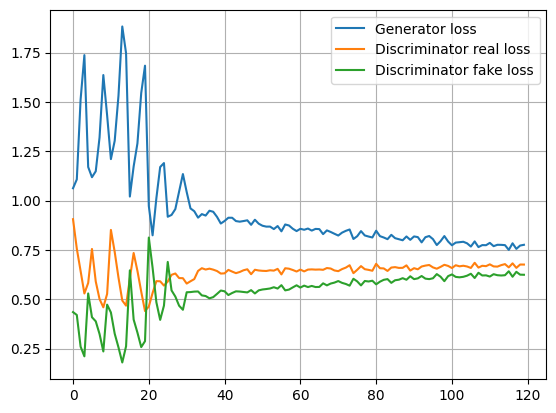

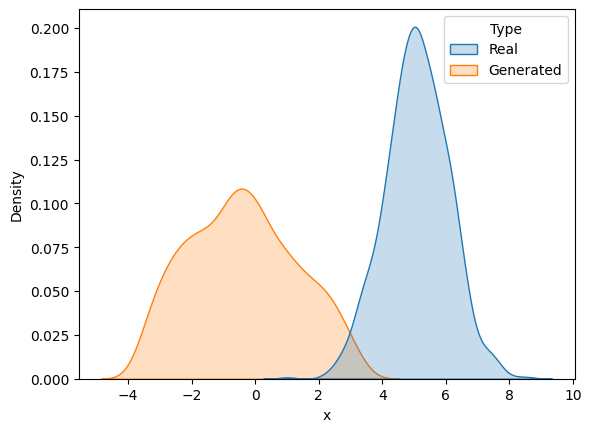

In [ ]:
conditional_q_fixed.to('cpu')

visualize_losses(losses, conditional_q_fixed.loss_titles, inner_steps=1)
visualize_gan(conditional_q_fixed, dataset)

In [ ]:
from copy import deepcopy

discriminator_backward = SimpleCritic(data_dim, hidden_dims).to(device)
discriminator_forward = SimpleCritic(data_dim, hidden_dims).to(device)

conditional_p = SimpleConditional(data_dim, hidden_dims).to(device)
conditional_q = deepcopy(conditional_q_fixed).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_disc={'forward': 4e-5, 'backward': 4e-5},
    lr_gen={'forward': 1e-5, 'backward': 1e-5},
    # clip=0.001,
    device=device
)

epochs = 80
inner_steps = 10
losses = trainer.train(epochs, dataloader, inner_steps=inner_steps)

Epochs:   0%|          | 0/80 [00:00<?, ?it/s]

======= Epoch 0 =======
Backward cond_p: -0.28373, disc_b_fixed: -0.23165, disc_b_training: -0.28385
Backward cond_p: 0.99555, disc_b_fixed: -0.31146, disc_b_training: 0.99489
Backward cond_p: 1.66834, disc_b_fixed: -0.26791, disc_b_training: 1.66830
Backward cond_p: 1.99952, disc_b_fixed: -0.17066, disc_b_training: 1.99945
Backward cond_p: 2.08107, disc_b_fixed: -0.11206, disc_b_training: 2.08110
Forward cond_q: 0.11598, disc_f_fixed: -0.56669, disc_f_training: 0.11587
Forward cond_q: 0.84751, disc_f_fixed: -0.33146, disc_f_training: 0.84384
Forward cond_q: 1.55291, disc_f_fixed: -0.27755, disc_f_training: 1.56263
Forward cond_q: 2.16279, disc_f_fixed: -0.20048, disc_f_training: 2.16318
Forward cond_q: 2.35231, disc_f_fixed: -0.21499, disc_f_training: 2.35589
======= Epoch 1 =======
Backward cond_p: 2.02779, disc_b_fixed: -0.31762, disc_b_training: 2.02537
Backward cond_p: 2.03402, disc_b_fixed: -0.17846, disc_b_training: 2.03334
Backward cond_p: 2.05206, disc_b_fixed: -0.16846, disc_

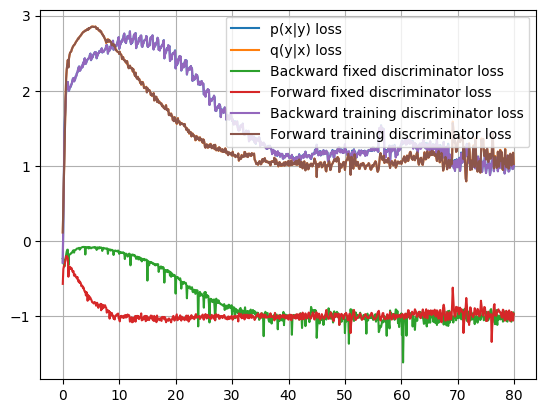

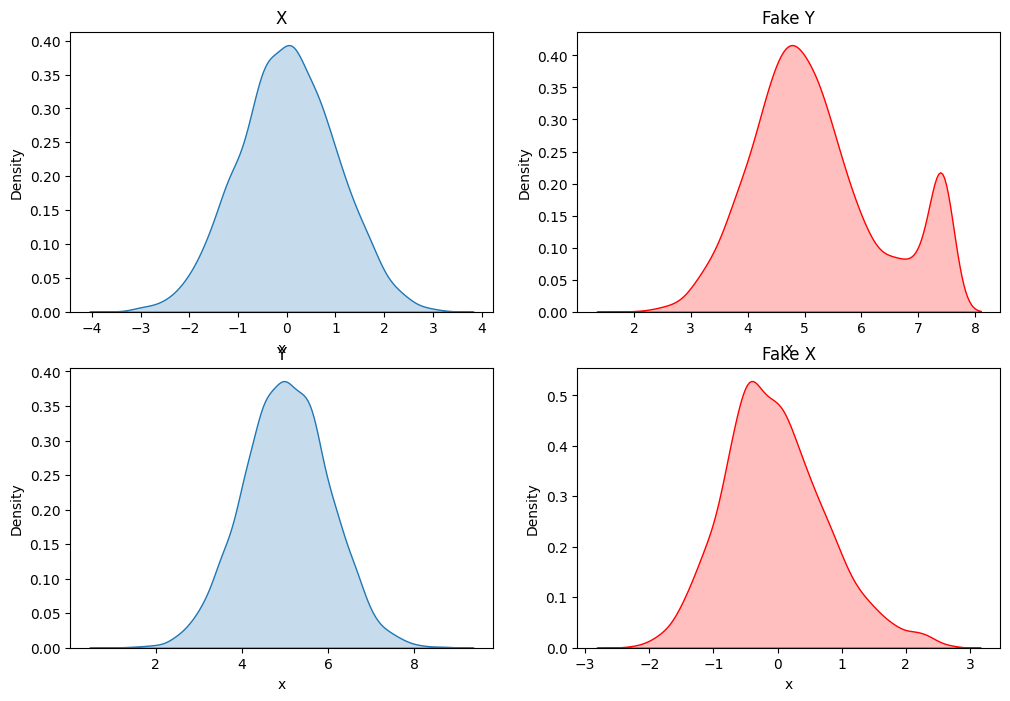

In [ ]:
conditional_q.to('cpu')
conditional_p.to('cpu')

visualize_losses(losses, trainer.loss_titles, inner_steps=inner_steps)
visualize_sb(conditional_p, conditional_q, dataset, num_samples=len(dataset))

## Two modes

In [ ]:
# Marginals
marginal_x = Normal(0, 1)
marginal_y = MixtureSameFamily(
    Categorical(torch.tensor([0.5, 0.5], dtype=torch.float)), 
    Normal(torch.tensor([20, -20], dtype=torch.float), torch.tensor([0.5, 0.5], dtype=torch.float))
)

# Trainer and dataloader parameters
batch_size = 128
dataset = OneVariateDataset(5_000, marginal_x, marginal_y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [13]:
# Models parameters
data_dim = 1
hidden_dims = [128, 64, 32]
conditional_q_fixed = SimpleConditional(data_dim, hidden_dims).to(device)

# Init conditional
init_params = {
    'epochs': 500,
    'loader': dataloader,
    'gamma': 10.,
    'lr_disc': 4e-4, 
    'lr_gen': 1e-4,    
}
losses = conditional_q_fixed.init_conditional(**init_params)

  0%|          | 0/500 [00:00<?, ?it/s]

AttributeError: 'list' object has no attribute 'to'

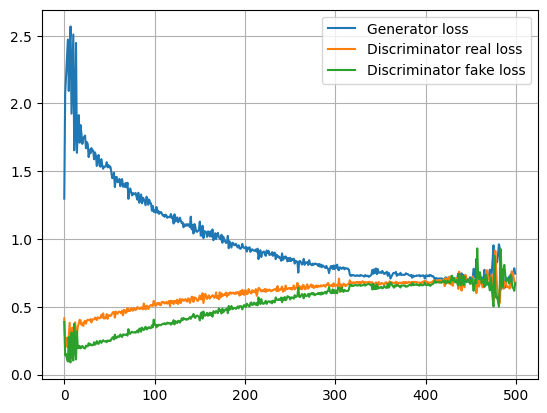

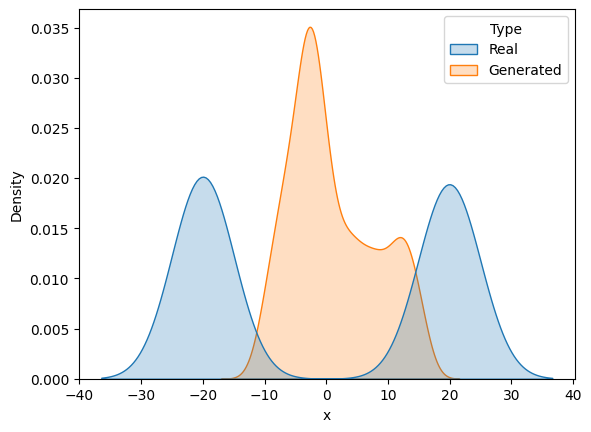

In [ ]:
conditional_q_fixed.to('cpu')

visualize_losses(losses, conditional_q_fixed.loss_titles, inner_steps=1)
visualize_gan(conditional_q_fixed, dataset)

In [ ]:
from copy import deepcopy

discriminator_backward = SimpleCritic(data_dim, hidden_dims).to(device)
discriminator_forward = SimpleCritic(data_dim, hidden_dims).to(device)

conditional_p = SimpleConditional(data_dim, hidden_dims).to(device)
conditional_q = deepcopy(conditional_q_fixed).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_disc={'forward': 4e-5, 'backward': 4e-5},
    lr_gen={'forward': 1e-5, 'backward': 1e-5},
    # clip=0.001,
    device=device
)

epochs = 100
inner_steps = 10
losses = trainer.train(epochs, dataloader, inner_steps=inner_steps)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

======= Epoch 0 =======
Backward cond_p: 0.06882, disc_b_fixed: -0.38241, disc_b_training: 0.06879
Backward cond_p: 0.98676, disc_b_fixed: -0.71167, disc_b_training: 0.98666
Backward cond_p: 1.46368, disc_b_fixed: -0.64175, disc_b_training: 1.46345
Backward cond_p: 1.90606, disc_b_fixed: -0.48748, disc_b_training: 1.90594
Backward cond_p: 2.20280, disc_b_fixed: -0.28178, disc_b_training: 2.20246
Forward cond_q: 0.23523, disc_f_fixed: -0.52472, disc_f_training: 0.23874
Forward cond_q: 0.98505, disc_f_fixed: -0.78373, disc_f_training: 0.98823
Forward cond_q: 1.17830, disc_f_fixed: -0.69772, disc_f_training: 1.18277
Forward cond_q: 1.40036, disc_f_fixed: -0.55383, disc_f_training: 1.38292
Forward cond_q: 1.66683, disc_f_fixed: -0.34991, disc_f_training: 1.66477
======= Epoch 1 =======
Backward cond_p: 2.44365, disc_b_fixed: -0.23275, disc_b_training: 2.44257
Backward cond_p: 2.45283, disc_b_fixed: -0.23858, disc_b_training: 2.44970
Backward cond_p: 2.42948, disc_b_fixed: -0.23914, disc_b_

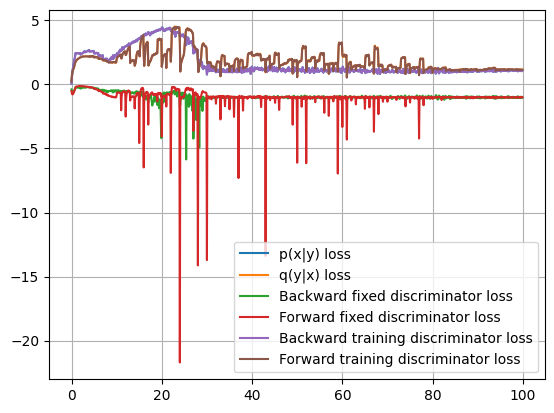

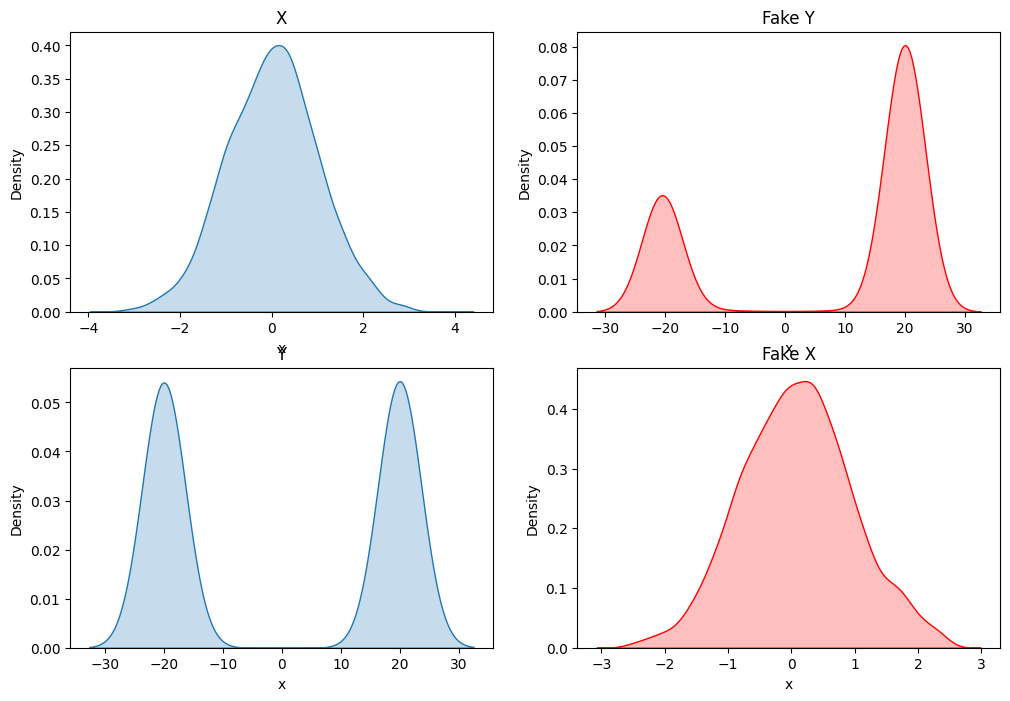

In [ ]:
conditional_q.to('cpu')
conditional_p.to('cpu')

visualize_losses(losses, trainer.loss_titles, inner_steps=inner_steps)
visualize_sb(conditional_p, conditional_q, dataset, num_samples=len(dataset))

In [ ]:
from copy import deepcopy

discriminator_backward = SimpleCritic(data_dim, hidden_dims).to(device)
discriminator_forward = SimpleCritic(data_dim, hidden_dims).to(device)

conditional_p = SimpleConditional(data_dim, hidden_dims).to(device)
conditional_q = deepcopy(conditional_q_fixed).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_disc={'forward': 4e-5, 'backward': 4e-5},
    lr_gen={'forward': 1e-5, 'backward': 1e-5},
    # clip=0.001,
    device=device
)

epochs = 200
inner_steps = 10
losses = trainer.train(epochs, dataloader, inner_steps=inner_steps)

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

======= Epoch 0 =======
Backward cond_p: 0.49170, disc_b_fixed: -0.56104, disc_b_training: 0.49169
Backward cond_p: 1.22511, disc_b_fixed: -0.81365, disc_b_training: 1.22504
Backward cond_p: 1.77094, disc_b_fixed: -0.65629, disc_b_training: 1.77089
Backward cond_p: 2.13138, disc_b_fixed: -0.46380, disc_b_training: 2.13141
Backward cond_p: 2.38483, disc_b_fixed: -0.29647, disc_b_training: 2.38470
Forward cond_q: 0.47034, disc_f_fixed: -0.59313, disc_f_training: 0.46639
Forward cond_q: 1.04808, disc_f_fixed: -0.73477, disc_f_training: 1.04901
Forward cond_q: 1.33726, disc_f_fixed: -0.63250, disc_f_training: 1.32820
Forward cond_q: 1.61513, disc_f_fixed: -0.35247, disc_f_training: 1.61887
Forward cond_q: 1.85230, disc_f_fixed: -0.12371, disc_f_training: 1.85272
======= Epoch 1 =======
Backward cond_p: 2.58021, disc_b_fixed: -0.17707, disc_b_training: 2.57999
Backward cond_p: 2.59820, disc_b_fixed: -0.16780, disc_b_training: 2.59848
Backward cond_p: 2.61076, disc_b_fixed: -0.17046, disc_b_

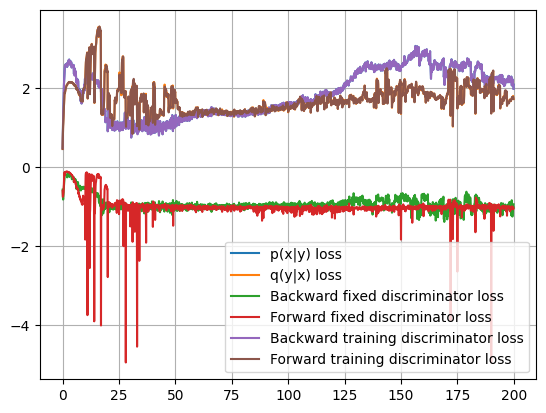

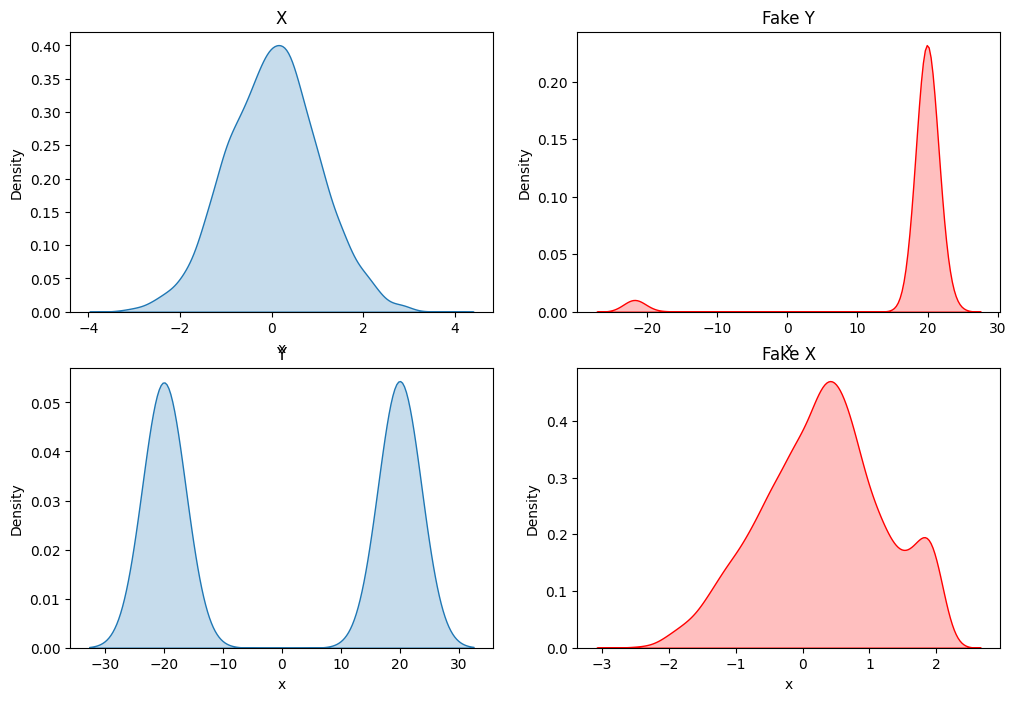

In [ ]:
conditional_q.to('cpu')
conditional_p.to('cpu')

visualize_losses(losses, trainer.loss_titles, inner_steps=inner_steps)
visualize_sb(conditional_p, conditional_q, dataset, num_samples=len(dataset))

In [ ]:
from copy import deepcopy

discriminator_backward = SimpleCritic(data_dim, hidden_dims).to(device)
discriminator_forward = SimpleCritic(data_dim, hidden_dims).to(device)

conditional_p = SimpleConditional(data_dim, hidden_dims).to(device)
conditional_q = deepcopy(conditional_q_fixed).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_disc={'forward': 5e-5, 'backward': 5e-5},
    lr_gen={'forward': 2e-5, 'backward': 2e-5},
    # clip=0.001,
    device=device
)

epochs = 150
inner_steps = 10
losses = trainer.train(epochs, dataloader, inner_steps=inner_steps)

Epochs:   0%|          | 0/150 [00:00<?, ?it/s]

======= Epoch 0 =======
Backward cond_p: 0.45783, disc_b_fixed: -0.64404, disc_b_training: 0.45779
Backward cond_p: 1.14569, disc_b_fixed: -0.77818, disc_b_training: 1.14552
Backward cond_p: 1.61054, disc_b_fixed: -0.51371, disc_b_training: 1.61032
Backward cond_p: 1.69893, disc_b_fixed: -0.46949, disc_b_training: 1.69885
Backward cond_p: 1.78507, disc_b_fixed: -0.41947, disc_b_training: 1.78381
Forward cond_q: 0.20120, disc_f_fixed: -0.50091, disc_f_training: 0.20646
Forward cond_q: 1.16796, disc_f_fixed: -0.72731, disc_f_training: 1.17349
Forward cond_q: 1.56670, disc_f_fixed: -0.55274, disc_f_training: 1.55276
Forward cond_q: 1.82607, disc_f_fixed: -0.23926, disc_f_training: 1.84101
Forward cond_q: 1.97565, disc_f_fixed: -0.15433, disc_f_training: 1.97312
======= Epoch 1 =======
Backward cond_p: 1.94056, disc_b_fixed: -0.66301, disc_b_training: 1.92121
Backward cond_p: 2.12373, disc_b_fixed: -0.46204, disc_b_training: 2.11118
Backward cond_p: 2.12963, disc_b_fixed: -0.48058, disc_b_

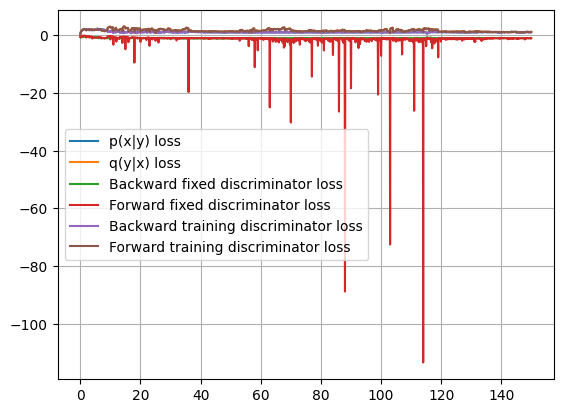

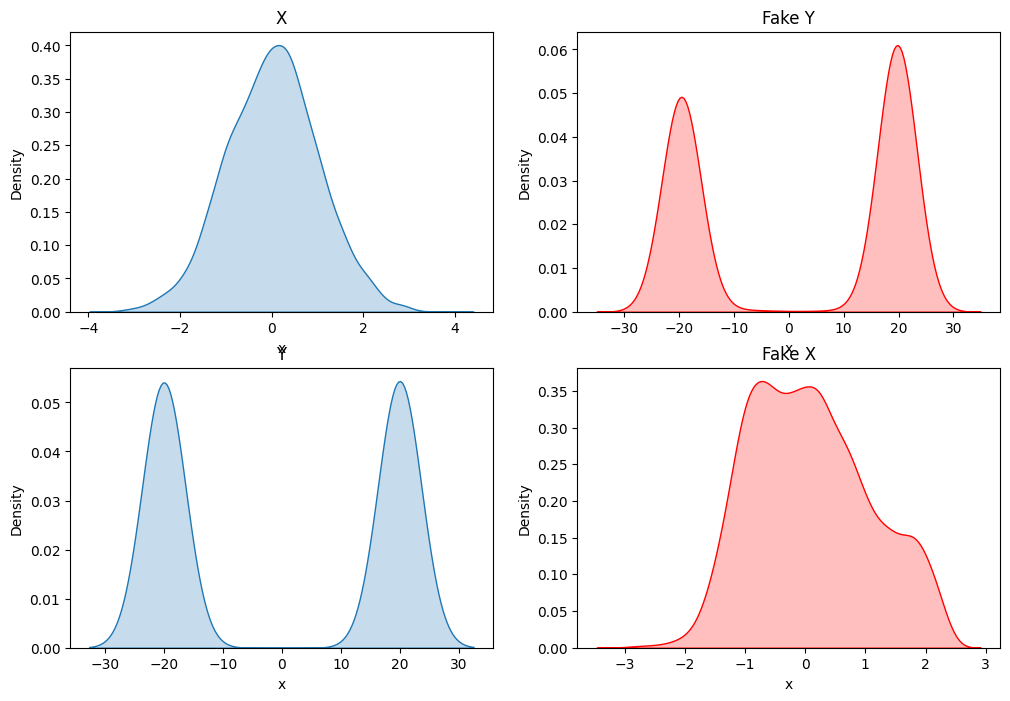

In [ ]:
conditional_q.to('cpu')
conditional_p.to('cpu')

visualize_losses(losses, trainer.loss_titles, inner_steps=inner_steps)
visualize_sb(conditional_p, conditional_q, dataset, num_samples=len(dataset))

# Two variate

In [48]:
batch_size = 512

moons_set = MoonsDataset(5_000)
circles_set = CirclesDataset(5_000)

moons = DataLoader(moons_set, batch_size=batch_size, shuffle=True)
circles = DataLoader(circles_set, batch_size=batch_size, shuffle=True)

In [61]:
# Models parameters
data_dim = 2
hidden_dims = [128, 64, 32]

conditional_q_fixed = SimpleConditional(data_dim, hidden_dims=hidden_dims).to(device)


init_params = {
    'epochs': 200,
    'loader': circles,
    'gamma': 1.,
    'lr_disc': 2e-4, 
    'lr_gen': 3e-5,    
}
losses = conditional_q_fixed.init_conditional(**init_params)

  0%|          | 0/200 [00:00<?, ?it/s]

gen Loss: 0.8569469153881073, disc Real Loss: 0.8462213635444641, disc Fake Loss: 0.5792583286762237
gen Loss: 1.251315414905548, disc Real Loss: 0.606168794631958, disc Fake Loss: 0.3775403708219528
gen Loss: 1.0409873366355895, disc Real Loss: 0.647255790233612, disc Fake Loss: 0.4566070407629013
gen Loss: 0.9119206428527832, disc Real Loss: 0.6208558559417725, disc Fake Loss: 0.5284339845180511
gen Loss: 0.8862276613712311, disc Real Loss: 0.6488446593284607, disc Fake Loss: 0.5459178388118744
gen Loss: 0.8397046983242035, disc Real Loss: 0.6451182663440704, disc Fake Loss: 0.5786201596260071
gen Loss: 0.8142479419708252, disc Real Loss: 0.6425329267978668, disc Fake Loss: 0.6025555789470672
gen Loss: 0.8253545582294464, disc Real Loss: 0.6669253885746003, disc Fake Loss: 0.5940275847911834
gen Loss: 0.7672482550144195, disc Real Loss: 0.6464646875858306, disc Fake Loss: 0.6559753298759461
gen Loss: 0.7967648506164551, disc Real Loss: 0.6651595830917358, disc Fake Loss: 0.6141361474

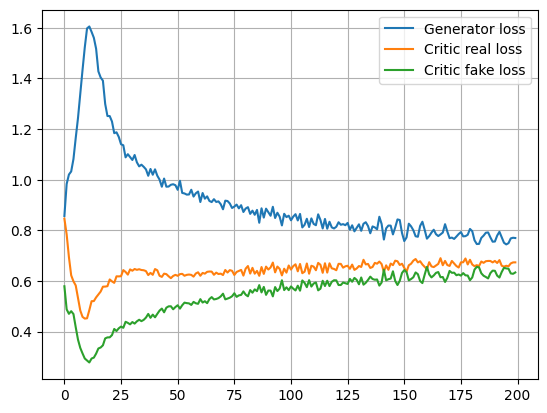

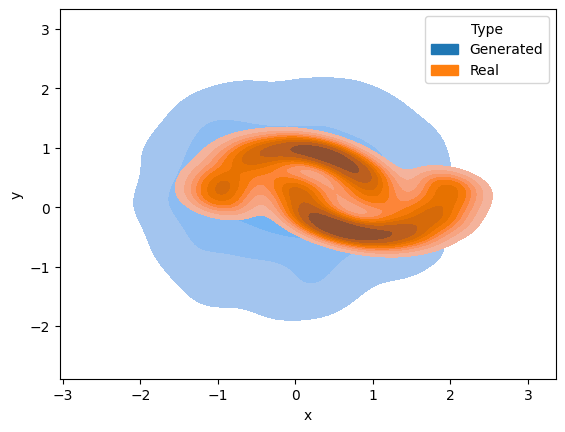

In [62]:
conditional_q_fixed.cpu()

visualize_losses(losses, conditional_q_fixed.loss_titles)
visualize_gan(conditional_q_fixed, circles_set, moons_set)

In [70]:
from copy import deepcopy

discriminator_backward = SimpleCritic(data_dim, hidden_dims=hidden_dims).to(device)
discriminator_forward = SimpleCritic(data_dim, hidden_dims=hidden_dims).to(device)

conditional_p = SimpleConditional(data_dim, hidden_dims=hidden_dims).to(device)
conditional_q = deepcopy(conditional_q_fixed).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_disc={'forward': 4e-5, 'backward': 4e-5},
    lr_gen={'forward': 1e-5, 'backward': 1e-5},
    # clip=0.01,
    device=device
)

losses = trainer.train(200, circles, moons, inner_steps=10)

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

======= Epoch 0 =======
Backward cond_p: -0.35178, disc_b_fixed: -0.26455, disc_b_training: -0.34912
Backward cond_p: -0.31852, disc_b_fixed: -0.27126, disc_b_training: -0.31969
Backward cond_p: -0.28901, disc_b_fixed: -0.27843, disc_b_training: -0.29325
Backward cond_p: -0.25906, disc_b_fixed: -0.28366, disc_b_training: -0.26020
Backward cond_p: -0.23166, disc_b_fixed: -0.29225, disc_b_training: -0.23082
Forward cond_q: -0.09842, disc_f_fixed: -0.32274, disc_f_training: -0.09176
Forward cond_q: -0.06791, disc_f_fixed: -0.33060, disc_f_training: -0.06902
Forward cond_q: -0.04602, disc_f_fixed: -0.33876, disc_f_training: -0.04582
Forward cond_q: -0.02445, disc_f_fixed: -0.34687, disc_f_training: -0.02390
Forward cond_q: 0.00213, disc_f_fixed: -0.35489, disc_f_training: 0.00211
======= Epoch 1 =======
Backward cond_p: -0.19993, disc_b_fixed: -0.30043, disc_b_training: -0.19939
Backward cond_p: -0.17079, disc_b_fixed: -0.30637, disc_b_training: -0.16866
Backward cond_p: -0.13847, disc_b_f

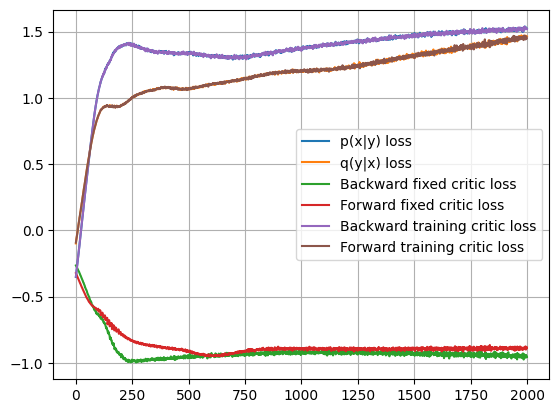

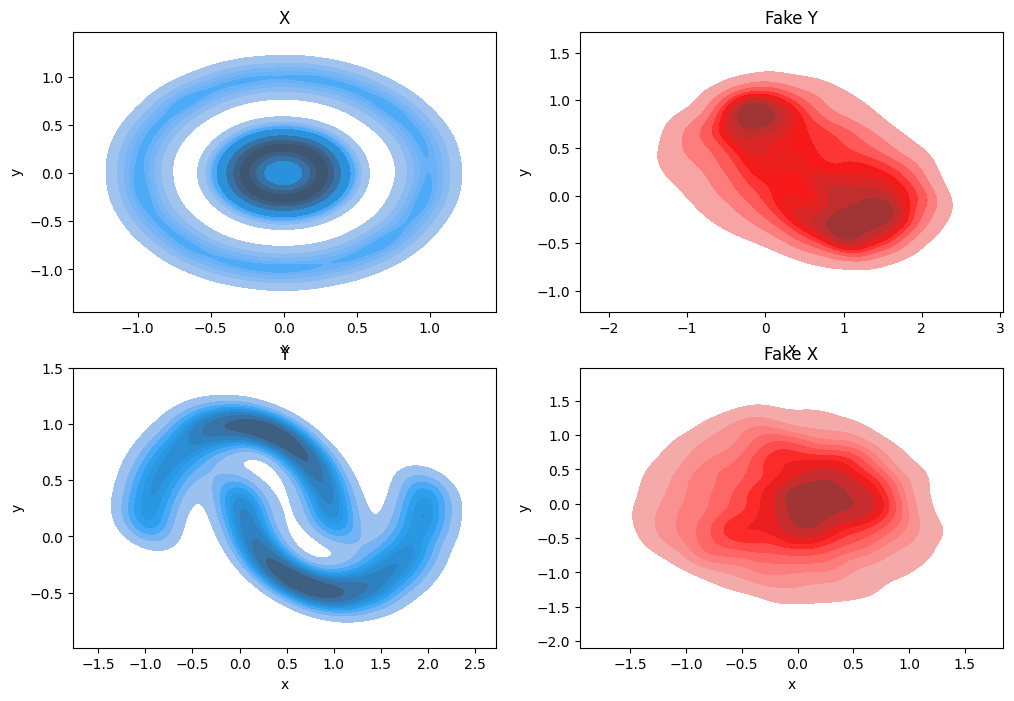

In [71]:
conditional_q.to('cpu')
conditional_p.to('cpu')

visualize_losses(losses, trainer.loss_titles)
visualize_sb(conditional_p, conditional_q, circles_set, moons_set, num_samples=len(circles_set))

In [78]:
from copy import deepcopy

discriminator_backward = SimpleCritic(data_dim, hidden_dims=hidden_dims).to(device)
discriminator_forward = SimpleCritic(data_dim, hidden_dims=hidden_dims).to(device)

conditional_p = SimpleConditional(data_dim, hidden_dims=hidden_dims).to(device)
conditional_q = deepcopy(conditional_q_fixed).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_disc={'forward': 4e-5, 'backward': 4e-5},
    lr_gen={'forward': 1e-5, 'backward': 1e-5},
    # clip=0.01,
    device=device
)

losses = trainer.train(200, circles, moons, inner_steps=20)

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

======= Epoch 0 =======
Backward cond_p: 0.19341, disc_b_fixed: -0.40444, disc_b_training: 0.19372
Backward cond_p: 0.48891, disc_b_fixed: -0.49353, disc_b_training: 0.48886
Backward cond_p: 0.74445, disc_b_fixed: -0.59248, disc_b_training: 0.74222
Backward cond_p: 0.95149, disc_b_fixed: -0.68612, disc_b_training: 0.94744
Backward cond_p: 1.11682, disc_b_fixed: -0.77107, disc_b_training: 1.11700
Backward cond_p: 1.25169, disc_b_fixed: -0.84364, disc_b_training: 1.25408
Backward cond_p: 1.34697, disc_b_fixed: -0.87968, disc_b_training: 1.34734
Backward cond_p: 1.39996, disc_b_fixed: -0.87038, disc_b_training: 1.40015
Backward cond_p: 1.41767, disc_b_fixed: -0.85962, disc_b_training: 1.41657
Backward cond_p: 1.41464, disc_b_fixed: -0.86519, disc_b_training: 1.41774
Forward cond_q: 0.03282, disc_f_fixed: -0.40771, disc_f_training: 0.03277
Forward cond_q: 0.33774, disc_f_fixed: -0.53100, disc_f_training: 0.34190
Forward cond_q: 0.59480, disc_f_fixed: -0.64537, disc_f_training: 0.59576
Forw

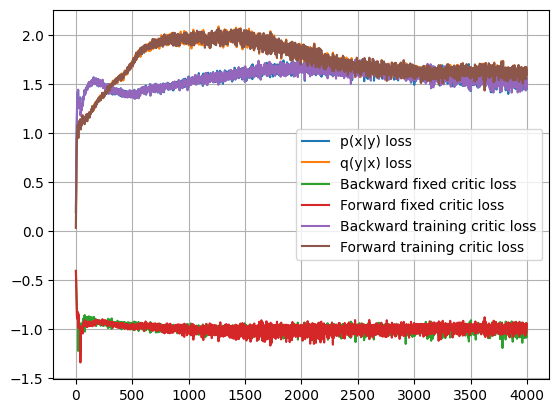

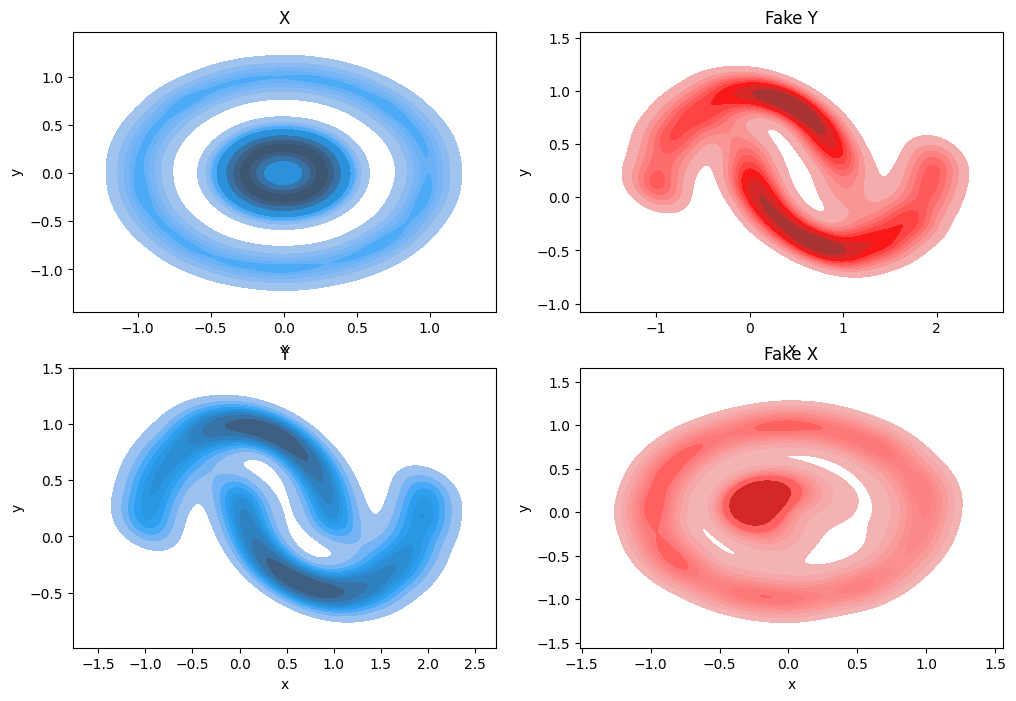

In [79]:
conditional_q.to('cpu')
conditional_p.to('cpu')

visualize_losses(losses, trainer.loss_titles)
visualize_sb(conditional_p, conditional_q, circles_set, moons_set, num_samples=len(circles_set))

# Images: Letters $\rightarrow$ Digits

In [37]:
hyper_params = {
    'data': {
        'batch_size': 128,
        'dataset': 'Letters <-> Digits'
    },
    'init_params': {
        'epochs': 200,
        'gamma': 1.,
        'lr_disc': 4e-4, 
        'lr_gen': 1e-4 
    },
    'train': {
        'lr_disc': {'forward': 4e-5, 'backward': 4e-5},
        'lr_gen': {'forward': 1e-5, 'backward': 1e-5},
        'epochs': 200,
        'inner_steps': 5,
        'clip': 0.1
    }
}
batch_size = hyper_params['data']['batch_size']

letters_set = LettersDataset('../data/emnist/emnist-letters-test.csv')
digits_set = DigitsDataset('../data/emnist/emnist-mnist-test.csv')

letters = DataLoader(letters_set, batch_size=batch_size, shuffle=True)
digits = DataLoader(digits_set, batch_size=batch_size, shuffle=True)

In [38]:
wandb.login()
wandb.init(
    project="adversarial-sb",
    notes="EMNIST",
    config=hyper_params
)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


loss_disc_fake,█▄▅▃▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▅▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_disc_real,█▃▄▂▂▂▂▁▂▂▂▂▁▂▁▁▂▁▁▃▂▂▂▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁
loss_gen,▁▂▂▃▄▅▅▆▆▅▆▆▇▇▇█▇██▆▇▇█▇▇▅▇▇████████▇█▇█
loss_disc_fake,0.07922
loss_disc_real,0.09167
loss_gen,28.86715


In [39]:
conditional_q_fixed = Conditional().to(device)

losses = conditional_q_fixed.init_conditional(loader=letters, **hyper_params['init_params'])
torch.save(conditional_q_fixed.state_dict(), '../models/conditional_q_fixed.pt')

  0%|          | 0/200 [00:00<?, ?it/s]

gen Loss: 0.6745322048664093, disc Real Loss: 0.49696755948765525, disc Fake Loss: 0.7678537810670918
gen Loss: 2.7565681276650262, disc Real Loss: 0.23433134338722147, disc Fake Loss: 0.22899037612409429
gen Loss: 4.002312606778638, disc Real Loss: 0.17959009175156726, disc Fake Loss: 0.1331366614021104
gen Loss: 5.107224341096549, disc Real Loss: 0.1318231462019271, disc Fake Loss: 0.10323059950666182
gen Loss: 6.224888209638925, disc Real Loss: 0.10503979329148243, disc Fake Loss: 0.09295665042410636
gen Loss: 7.344659603875259, disc Real Loss: 0.09105620619937263, disc Fake Loss: 0.09017586335539818
gen Loss: 8.255357943732163, disc Real Loss: 0.08931569959004891, disc Fake Loss: 0.09059556756682437
gen Loss: 9.3706832507561, disc Real Loss: 0.08079807065298845, disc Fake Loss: 0.09058835826300342
gen Loss: 10.015438252481921, disc Real Loss: 0.07903046228376956, disc Fake Loss: 0.09576178971549561
gen Loss: 10.580578968442719, disc Real Loss: 0.07912259141047454, disc Fake Loss: 0

In [35]:
conditional_q_fixed = Conditional().to(device)
conditional_q_fixed.load_state_dict(torch.load('../models/conditional_q_fixed.pt'))

<All keys matched successfully>

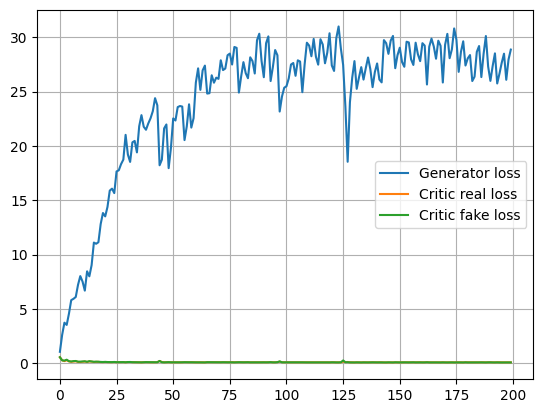

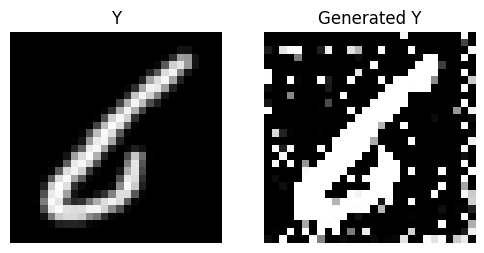

In [36]:
conditional_q_fixed.cpu().eval()

visualize_losses(losses, conditional_q_fixed.loss_titles)
visualize_gan_images(conditional_q_fixed, letters_set)

In [41]:
from copy import deepcopy

discriminator_backward = Critic().to(device)
discriminator_forward = Critic().to(device)

conditional_q_fixed.train()
conditional_p = Conditional().to(device)
conditional_q = deepcopy(conditional_q_fixed).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_disc=hyper_params['train']['lr_disc'],
    lr_gen=hyper_params['train']['lr_gen'],
    clip=hyper_params['train']['clip'],
    device=device
)

losses = trainer.train(hyper_params['train']['epochs'], letters, digits, inner_steps=hyper_params['train']['inner_steps'])

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

======= Epoch 0 =======
Backward cond_p: 0.38682, disc_b_fixed: -0.58895, disc_b_training: 0.38328
Backward cond_p: 0.59850, disc_b_fixed: -0.53227, disc_b_training: 0.59741
Backward cond_p: 0.70711, disc_b_fixed: -0.49603, disc_b_training: 0.70422
Forward cond_q: -0.43522, disc_f_fixed: -0.24707, disc_f_training: -0.44008
Forward cond_q: -0.19305, disc_f_fixed: -0.19051, disc_f_training: -0.19552
Forward cond_q: -0.12565, disc_f_fixed: -0.16858, disc_f_training: -0.11174
======= Epoch 1 =======
Backward cond_p: 0.73685, disc_b_fixed: -0.48348, disc_b_training: 0.74032
Backward cond_p: 0.77767, disc_b_fixed: -0.45894, disc_b_training: 0.77693
Backward cond_p: 0.81722, disc_b_fixed: -0.45481, disc_b_training: 0.81783
Forward cond_q: -0.10613, disc_f_fixed: -0.19345, disc_f_training: -0.10261
Forward cond_q: -0.05604, disc_f_fixed: -0.17755, disc_f_training: -0.05611
Forward cond_q: -0.00656, disc_f_fixed: -0.17403, disc_f_training: -0.00917
======= Epoch 2 =======
Backward cond_p: 0.823

In [6]:
wandb.finish()

loss_disc_fake,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_disc_real,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_gen,▁▂▃▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇████████████████████
loss_disc_fake,0.09178
loss_disc_real,0.07708
loss_gen,12.98073


In [76]:
conditional_q.to('cpu')
conditional_p.to('cpu')

conditional_q.eval()
conditional_p.eval()

# visualize_losses(losses, trainer.loss_titles, inner_steps=hyper_params['train']['inner_steps'])
visualize_sb_images(conditional_q, conditional_p, letters_set, digits_set, x_title='Letter', y_title='Digit')

NameError: name 'dataset' is not defined

In [ ]:
torch.save(conditional_p.state_dict(), '../models/conditional_p.pt')
torch.save(conditional_q.state_dict(), '../models/conditional_q.pt')

In [ ]:
from copy import deepcopy

In [77]:
conditional_p = Conditional()
conditional_p.load_state_dict(torch.load('../models/emnist_conditional_p.pt'))

conditional_q = Conditional()
conditional_q.load_state_dict(torch.load('../models/emnist_conditional_q.pt'))

RuntimeError: Error(s) in loading state_dict for Conditional:
	Missing key(s) in state_dict: "gen.conv1.conv.weight", "gen.conv1.conv.bias", "gen.conv1.norm.weight", "gen.conv1.norm.bias", "gen.conv1.norm.running_mean", "gen.conv1.norm.running_var", "gen.conv2.conv.weight", "gen.conv2.conv.bias", "gen.conv2.norm.weight", "gen.conv2.norm.bias", "gen.conv2.norm.running_mean", "gen.conv2.norm.running_var", "gen.conv_transpose1.conv.weight", "gen.conv_transpose1.conv.bias", "gen.conv_transpose1.norm.weight", "gen.conv_transpose1.norm.bias", "gen.conv_transpose1.norm.running_mean", "gen.conv_transpose1.norm.running_var", "gen.conv_transpose2.weight", "gen.conv_transpose2.bias". 
	Unexpected key(s) in state_dict: "gen.encoding_layer1_.layer.0.weight", "gen.encoding_layer1_.layer.1.weight", "gen.encoding_layer1_.layer.1.bias", "gen.encoding_layer1_.layer.1.running_mean", "gen.encoding_layer1_.layer.1.running_var", "gen.encoding_layer1_.layer.1.num_batches_tracked", "gen.encoding_layer1_.layer.3.weight", "gen.encoding_layer1_.layer.4.weight", "gen.encoding_layer1_.layer.4.bias", "gen.encoding_layer1_.layer.4.running_mean", "gen.encoding_layer1_.layer.4.running_var", "gen.encoding_layer1_.layer.4.num_batches_tracked", "gen.encoding_layer1_.identity_map.weight", "gen.encoding_layer1_.identity_map.bias", "gen.encoding_layer2_.layer.1.layer.0.weight", "gen.encoding_layer2_.layer.1.layer.1.weight", "gen.encoding_layer2_.layer.1.layer.1.bias", "gen.encoding_layer2_.layer.1.layer.1.running_mean", "gen.encoding_layer2_.layer.1.layer.1.running_var", "gen.encoding_layer2_.layer.1.layer.1.num_batches_tracked", "gen.encoding_layer2_.layer.1.layer.3.weight", "gen.encoding_layer2_.layer.1.layer.4.weight", "gen.encoding_layer2_.layer.1.layer.4.bias", "gen.encoding_layer2_.layer.1.layer.4.running_mean", "gen.encoding_layer2_.layer.1.layer.4.running_var", "gen.encoding_layer2_.layer.1.layer.4.num_batches_tracked", "gen.encoding_layer2_.layer.1.identity_map.weight", "gen.encoding_layer2_.layer.1.identity_map.bias", "gen.encoding_layer3_.layer.1.layer.0.weight", "gen.encoding_layer3_.layer.1.layer.1.weight", "gen.encoding_layer3_.layer.1.layer.1.bias", "gen.encoding_layer3_.layer.1.layer.1.running_mean", "gen.encoding_layer3_.layer.1.layer.1.running_var", "gen.encoding_layer3_.layer.1.layer.1.num_batches_tracked", "gen.encoding_layer3_.layer.1.layer.3.weight", "gen.encoding_layer3_.layer.1.layer.4.weight", "gen.encoding_layer3_.layer.1.layer.4.bias", "gen.encoding_layer3_.layer.1.layer.4.running_mean", "gen.encoding_layer3_.layer.1.layer.4.running_var", "gen.encoding_layer3_.layer.1.layer.4.num_batches_tracked", "gen.encoding_layer3_.layer.1.identity_map.weight", "gen.encoding_layer3_.layer.1.identity_map.bias", "gen.bridge.layer.1.layer.0.weight", "gen.bridge.layer.1.layer.1.weight", "gen.bridge.layer.1.layer.1.bias", "gen.bridge.layer.1.layer.1.running_mean", "gen.bridge.layer.1.layer.1.running_var", "gen.bridge.layer.1.layer.1.num_batches_tracked", "gen.bridge.layer.1.layer.3.weight", "gen.bridge.layer.1.layer.4.weight", "gen.bridge.layer.1.layer.4.bias", "gen.bridge.layer.1.layer.4.running_mean", "gen.bridge.layer.1.layer.4.running_var", "gen.bridge.layer.1.layer.4.num_batches_tracked", "gen.bridge.layer.1.identity_map.weight", "gen.bridge.layer.1.identity_map.bias", "gen.decoding_layer3_.res_block.layer.0.weight", "gen.decoding_layer3_.res_block.layer.1.weight", "gen.decoding_layer3_.res_block.layer.1.bias", "gen.decoding_layer3_.res_block.layer.1.running_mean", "gen.decoding_layer3_.res_block.layer.1.running_var", "gen.decoding_layer3_.res_block.layer.1.num_batches_tracked", "gen.decoding_layer3_.res_block.layer.3.weight", "gen.decoding_layer3_.res_block.layer.4.weight", "gen.decoding_layer3_.res_block.layer.4.bias", "gen.decoding_layer3_.res_block.layer.4.running_mean", "gen.decoding_layer3_.res_block.layer.4.running_var", "gen.decoding_layer3_.res_block.layer.4.num_batches_tracked", "gen.decoding_layer3_.res_block.identity_map.weight", "gen.decoding_layer3_.res_block.identity_map.bias", "gen.decoding_layer2_.res_block.layer.0.weight", "gen.decoding_layer2_.res_block.layer.1.weight", "gen.decoding_layer2_.res_block.layer.1.bias", "gen.decoding_layer2_.res_block.layer.1.running_mean", "gen.decoding_layer2_.res_block.layer.1.running_var", "gen.decoding_layer2_.res_block.layer.1.num_batches_tracked", "gen.decoding_layer2_.res_block.layer.3.weight", "gen.decoding_layer2_.res_block.layer.4.weight", "gen.decoding_layer2_.res_block.layer.4.bias", "gen.decoding_layer2_.res_block.layer.4.running_mean", "gen.decoding_layer2_.res_block.layer.4.running_var", "gen.decoding_layer2_.res_block.layer.4.num_batches_tracked", "gen.decoding_layer2_.res_block.identity_map.weight", "gen.decoding_layer2_.res_block.identity_map.bias", "gen.decoding_layer1_.res_block.layer.0.weight", "gen.decoding_layer1_.res_block.layer.1.weight", "gen.decoding_layer1_.res_block.layer.1.bias", "gen.decoding_layer1_.res_block.layer.1.running_mean", "gen.decoding_layer1_.res_block.layer.1.running_var", "gen.decoding_layer1_.res_block.layer.1.num_batches_tracked", "gen.decoding_layer1_.res_block.layer.3.weight", "gen.decoding_layer1_.res_block.layer.4.weight", "gen.decoding_layer1_.res_block.layer.4.bias", "gen.decoding_layer1_.res_block.layer.4.running_mean", "gen.decoding_layer1_.res_block.layer.4.running_var", "gen.decoding_layer1_.res_block.layer.4.num_batches_tracked", "gen.decoding_layer1_.res_block.identity_map.weight", "gen.decoding_layer1_.res_block.identity_map.bias", "gen.output.weight", "gen.output.bias". 